In [6]:
import os
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, Dropout
from tensorflow.keras.utils import to_categorical

In [7]:
train_data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'

In [8]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size= IMG_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 14034 images belonging to 6 classes.


In [9]:
def display_images_per_category(generator, categories, images_per_category=3):
    # Dictionary to store images for each category
    category_images = {category: [] for category in categories}
    
    # Iterate over the dataset to fetch images
    for images, labels in generator:
        for i, label in enumerate(labels):
            category = categories[np.argmax(label)]
            if len(category_images[category]) < images_per_category:
                category_images[category].append(images[i])
        
        # Stop when we have enough images for each category
        if all(len(imgs) >= images_per_category for imgs in category_images.values()):
            break

    # Plot the images
    num_categories = len(categories)
    plt.figure(figsize=(num_categories * 3, images_per_category * 3))
    
    for col_idx, category in enumerate(categories):
        for row_idx in range(images_per_category):
            # Only plot if there are enough images
            if row_idx < len(category_images[category]):
                plt.subplot(images_per_category, num_categories, row_idx * num_categories + col_idx + 1)
                plt.imshow(category_images[category][row_idx])
                plt.axis('off')
                
                # Show category name at the top of the first row
                if row_idx == 0:
                    plt.title(category)
    
    plt.tight_layout()
    plt.show()

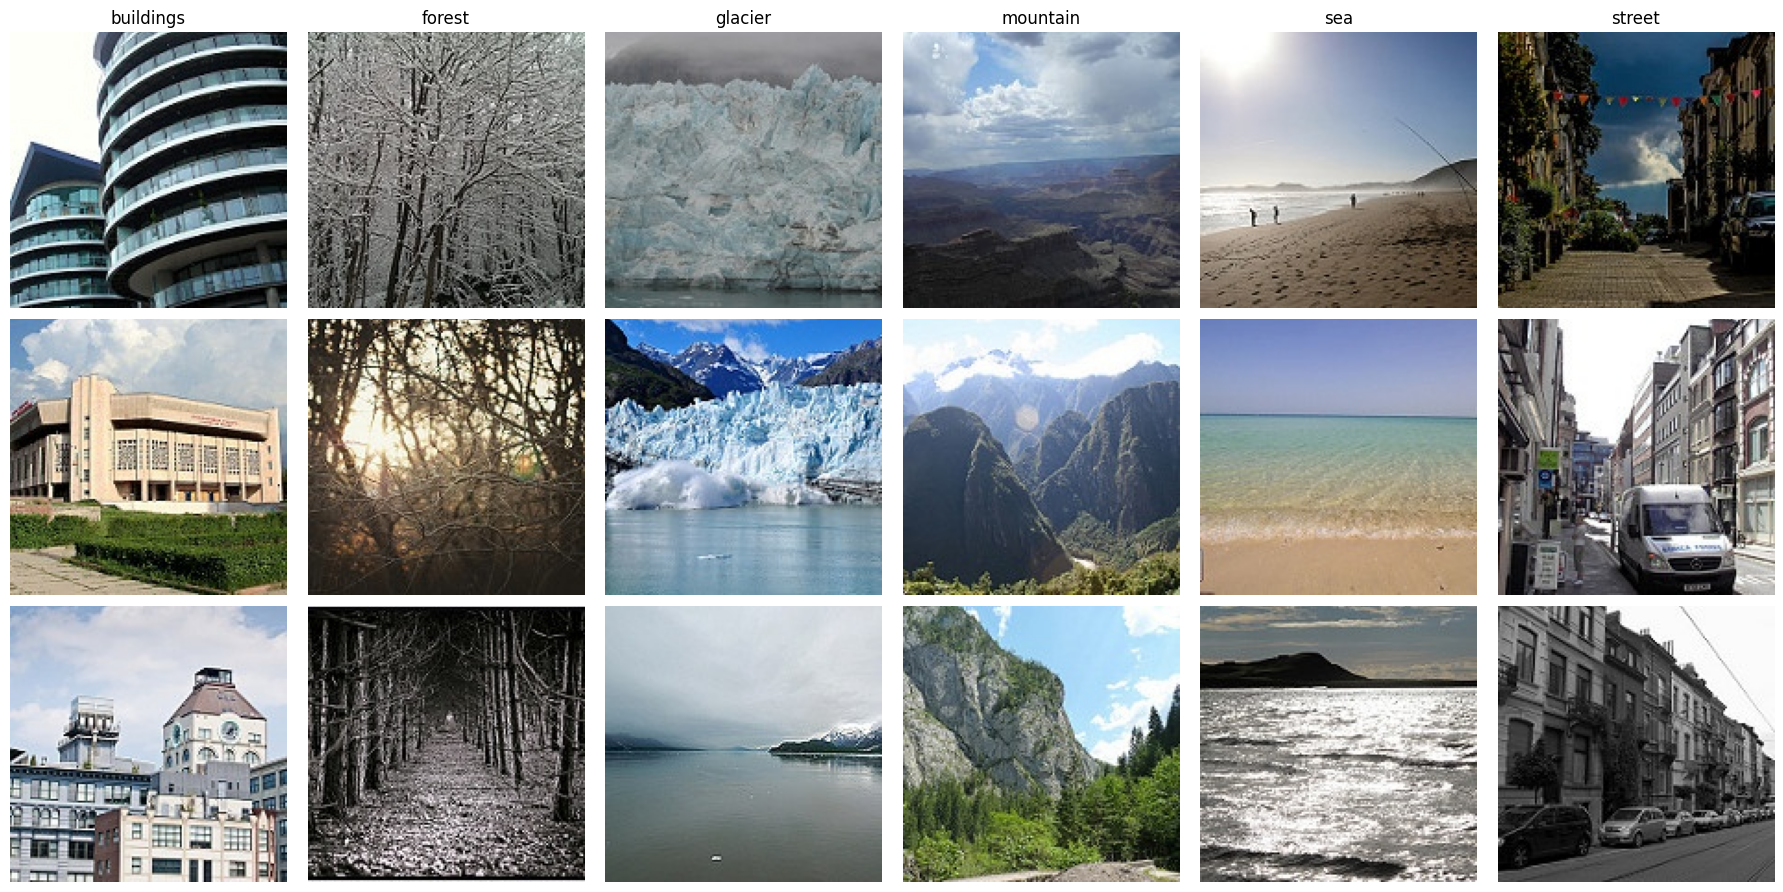

In [10]:
category_names = list(train_generator.class_indices.keys())
display_images_per_category(train_generator,category_names,images_per_category = 3)

In [11]:
input_shape = train_generator.image_shape
category_count = len(category_names)

In [16]:
class AlexNet(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()
        self.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape= input_shape, padding='valid'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
        self.add(ZeroPadding2D(padding=2))
        self.add(Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
        self.add(Conv2D(384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
        self.add(Conv2D(384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
        self.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
        self.add(Flatten())
        self.add(Dense(4096, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(nb_classes, activation='softmax'))
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-3,
            decay_steps = 10000,
            decay_rate = 0.98
        )
        
        adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        self.summary()

In [17]:
alex_net = AlexNet(input_shape, category_count)

Model: "alex_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 35, 35, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 21, 21, 96)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    67,112,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,666,054 (334.42 MB)

 Trainable params: 87,666,054 (334.42 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
class Model:
    def __init__(self, model):
        self.model = model
        
    def train(self,train_data):
        history = self.model.fit(
              train_data,
              steps_per_epoch= len(train_data),
              epochs=50)
        
        self.model.summary()

In [19]:
model = Model(alex_net)
model.train(train_generator)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.2058 - loss: 1.9211
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5223 - loss: 1.2476
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.5642 - loss: 1.1159
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5823 - loss: 1.0862
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.6206 - loss: 0.9997
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.6426 - loss: 0.9427
Epoch 12/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.6593 - loss: 0.8876
Epoc

Model: "alex_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 35, 35, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 21, 21, 96)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    67,112,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,998,163 (1003.26 MB)

 Trainable params: 87,666,054 (334.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 175,332,109 (668.84 MB)